In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
from tqdm import tqdm
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('max_colwidth', 800)
from scipy import signal

/tmp/ipykernel_329518/335835994.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
data_dir = 'data_by_days'
NUM_TRAIN_FILES = 1

df = pd.concat([pd.read_feather(f'{data_dir}/train_{i}.feather') for i in tqdm(range(NUM_TRAIN_FILES))])
df.reset_index(drop=True, inplace=True)
df.head(5)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.30it/s]


,timestamp,target,MIRAMAR_bid0_price,MIRAMAR_bid0_qty,MIRAMAR_bid1_price,MIRAMAR_bid1_qty,MIRAMAR_bid2_price,MIRAMAR_bid2_qty,MIRAMAR_bid3_price,MIRAMAR_bid3_qty,...,LIVIK_ask0_price,LIVIK_ask0_qty,LIVIK_ask1_price,LIVIK_ask1_qty,LIVIK_ask2_price,LIVIK_ask2_qty,LIVIK_ask3_price,LIVIK_ask3_qty,LIVIK_ask4_price,LIVIK_ask4_qty
0,1970-01-01 02:00:00.000000000,-1.0,26788.0,6.0,26787.0,4.0,26783.0,11.0,26782.0,1.0,...,18978.0,1.0,18980.0,2.0,18985.0,1.0,18988.0,3.0,18995.0,1.0
1,1970-01-01 02:00:00.499097340,47.5,26788.0,6.0,26787.0,4.0,26783.0,11.0,26782.0,1.0,...,18978.0,1.0,18980.0,2.0,18985.0,1.0,18988.0,3.0,18995.0,1.0
2,1970-01-01 02:00:00.499100368,47.5,26810.0,1.0,26805.0,10.0,26803.0,3.0,26801.0,28.0,...,18978.0,1.0,18980.0,2.0,18985.0,1.0,18988.0,3.0,18995.0,1.0
3,1970-01-01 02:00:00.499143008,48.5,26810.0,1.0,26805.0,10.0,26803.0,3.0,26801.0,28.0,...,18978.0,1.0,18980.0,2.0,18985.0,1.0,18988.0,3.0,18995.0,1.0
4,1970-01-01 02:00:00.502273623,48.5,26810.0,1.0,26805.0,10.0,26803.0,3.0,26801.0,28.0,...,18978.0,1.0,18980.0,2.0,18985.0,1.0,18988.0,3.0,18995.0,1.0


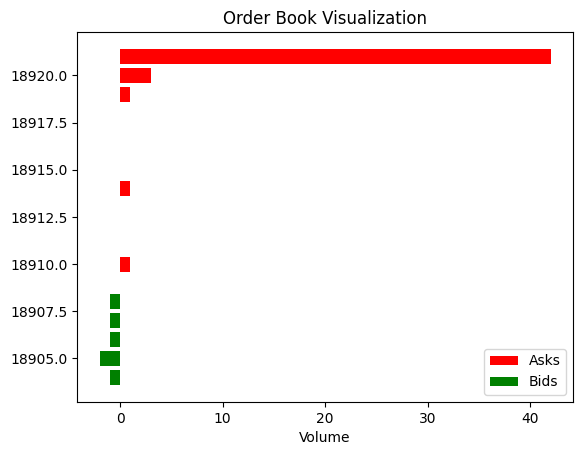

In [3]:
def draw_orderbook(df, number_of_snapshot, instrument='SANHOK'):
    ask_prices_columns = [column for column in df.columns if column.startswith(f'{instrument}_ask') and column.endswith('price')]
    bid_prices_columns = [column for column in df.columns if column.startswith(f'{instrument}_bid') and column.endswith('price')]
    ask_vol_columns = [column for column in df.columns if column.startswith(f'{instrument}_ask') and column.endswith('qty')]
    bid_vol_columns = [column for column in df.columns if column.startswith(f'{instrument}_bid') and column.endswith('qty')]
    assert number_of_snapshot < len(df)
    ask_prices = df.loc[number_of_snapshot, ask_prices_columns].values
    bid_prices = df.loc[number_of_snapshot, bid_prices_columns].values
    ask_volumes = df.loc[number_of_snapshot, ask_vol_columns].values
    bid_volumes = df.loc[number_of_snapshot, bid_vol_columns].values
    _, ax = plt.subplots()

    ax.barh(ask_prices, ask_volumes, color='red', label='Asks')
    
    ax.barh(bid_prices, -bid_volumes, color='green', label='Bids')

    ax.set_xlabel('Volume')
    ax.set_title('Order Book Visualization')

    ax.legend()
    plt.show()


draw_orderbook(df, 500)

In [4]:
@njit
def get_future_price(ts, values, window):
    price_pointer = 0
    res = np.zeros(ts.size)
    for X_pointer in range(len(ts)):
        while price_pointer + 1 < len(ts) and ts[price_pointer] < ts[X_pointer] + window:
            price_pointer += 1
        res[X_pointer] = values[price_pointer]
    return res

for i in tqdm(range(NUM_TRAIN_FILES)):
    day_df = pd.read_feather(f'{data_dir}/train_{i}.feather')
    ts = ((day_df.timestamp - pd.to_datetime('1970-01-01')) // pd.Timedelta('1ns')).values
    midprice = ((day_df.SANHOK_bid0_price + day_df.SANHOK_ask0_price) / 2).values
    window = pd.Timedelta('500ms') // pd.Timedelta('1ns')
    future_price = get_future_price(ts, midprice, window)
    assert all(day_df['target'] == get_future_price(ts, midprice, window) - midprice)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


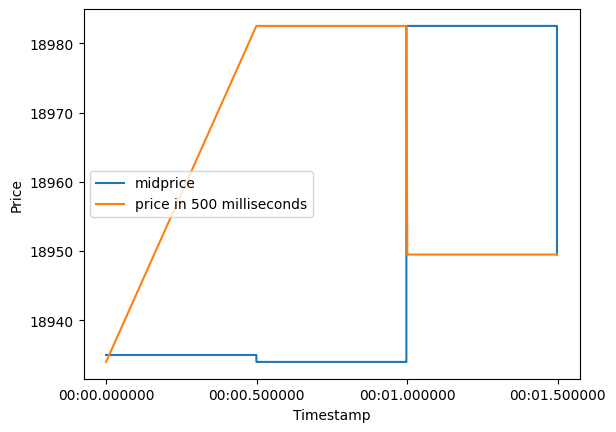

In [5]:
n = 16
_, ax = plt.subplots()
ax.plot(day_df.timestamp[:n], midprice[:n], label='midprice')
ax.plot(day_df.timestamp[:n], future_price[:n], label='price in 500 milliseconds')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Price')
ax.legend()
plt.show()

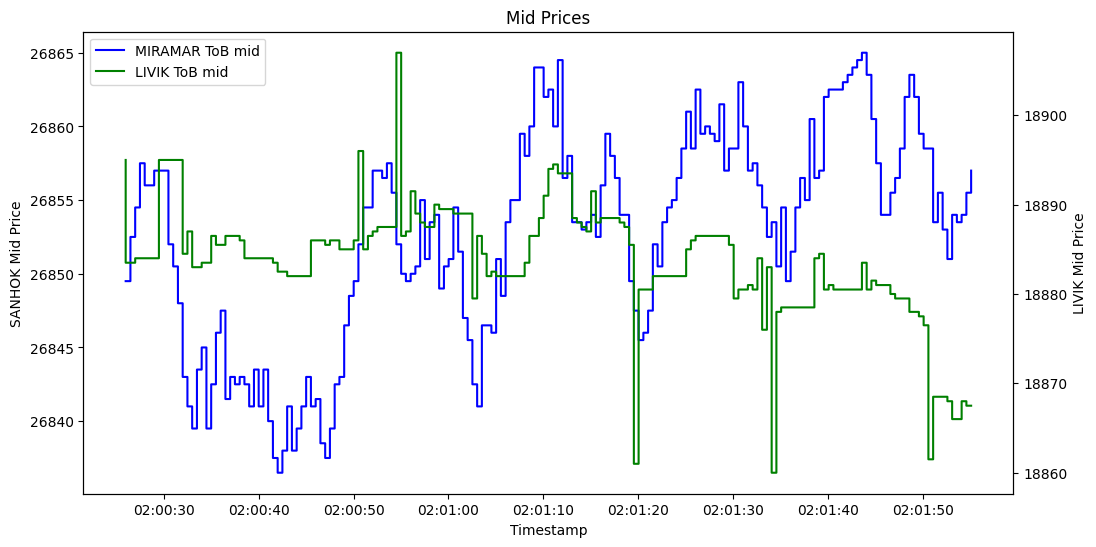

In [6]:
data = df.set_index("timestamp")[0:10000]
instruments = ["MIRAMAR", "LIVIK", "SANHOK", "ERANGEL", "VIKENDI", "KARAKIN"]
for i in instruments:
    data[i + "_ToB_mid"] = (data[i + "_bid0_price"] + data[i + "_ask0_price"]) / 2
    
# plot the bid and ask prices over time
ind1 = 300
ind2 = 1300
instrument1 = "MIRAMAR"
instrument2 = "LIVIK"
# create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# plot the bid and ask prices for the first instrument
ax1.plot(data[ind1:ind2].index, data[ind1:ind2][instrument1 + '_ToB_mid'], label= instrument1 +' ToB mid', color='blue')
# ax1.plot(data[ind1:ind2].index, data[ind1:ind2]['MIRAMAR_ask0_price'], label='MIRAMAR Ask', color='blue')

# plot the bid and ask prices for the second instrument on the right y-axis
ax2.plot(data[ind1:ind2].index, data[ind1:ind2][instrument2 + '_ToB_mid'], label=instrument2 + ' ToB mid', color='green')
# ax2.plot(data[ind1:ind2].index, data[ind1:ind2]['LIVIK_ask0_price'], label='LIVIK Ask', color='green')

# set the labels and title
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('SANHOK Mid Price')
ax2.set_ylabel('LIVIK Mid Price')
plt.title('Mid Prices')

# add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# display the plot
plt.show()

In [7]:
# # create a figure with subplots
# fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(18, 18), sharex=True)
# ind1 = 0
# ind2 = -1

# for i, instrument1 in enumerate(instruments):
#     for j, instrument2 in enumerate(instruments):
#         # create a twin y-axis for the second instrument
#         ax2 = axs[i][j].twinx()
#         # plot the bid and ask prices for the first instrument
#         axs[i][j].plot(data[ind1:ind2].index, data[ind1:ind2][instrument1 + '_ToB_mid'], label= instrument1 +' ToB mid', color='blue')
#         # plot the bid and ask prices for the second instrument on the right y-axis
#         ax2.plot(data[ind1:ind2].index, data[ind1:ind2][instrument2 + '_ToB_mid'], label=instrument2 + ' ToB mid', color='red')
#         # set the labels and title
#         axs[i][j].set_xlabel('Timestamp')
#         axs[i][j].set_ylabel(instrument1 + ' Mid Price', color='blue')
#         ax2.set_ylabel(instrument2 + ' Mid Price', color='green')
#         axs[i][j].set_title(instrument1 + ' vs. ' + instrument2)
#         # add a legend
#         lines, labels = axs[i][j].get_legend_handles_labels()
#         lines2, labels2 = ax2.get_legend_handles_labels()
#         axs[i][j].legend(lines + lines2, labels + labels2, loc='upper left')

# # adjust the space between the subplots and display the plot
# plt.subplots_adjust(hspace=0.5, wspace=0.5)
# plt.show()


In [8]:
# temp_data = data[["SANHOK_ToB_mid", "LIVIK_ToB_mid"]]
# temp_data = temp_data.drop_duplicates()
# temp_data1 = np.log(temp_data[["SANHOK_ToB_mid"]]).diff().dropna() + 5
# temp_data2 = np.log(temp_data[["LIVIK_ToB_mid"]]).diff().dropna() + 5

# corr1 = signal.correlate(temp_data1, temp_data2 , mode='full')

# plt.plot(corr1)
# delay = (np.argmax(corr1) - len(temp_data1['SANHOK_ToB_mid']) + 1)
# print("Estimated delay: " + str(delay) +" or ~ " + str(temp_data1.index[abs(delay)]-temp_data1.index[0]) + " seconds")


In [9]:
# ind1=500
# ind2=ind1 + 50
# # create a figure with two y-axes
# fig, ax1 = plt.subplots(figsize=(12, 6))
# ax2 = ax1.twinx()

# # plot the bid and ask prices for the first instrument
# ax1.plot(temp_data1[ind1:ind2].index, temp_data1[ind1:ind2], label= "SANHOK_ToB_mid", color='blue')

# # plot the bid and ask prices for the second instrument on the right y-axis
# ax2.plot(temp_data2[ind1:ind2].index, temp_data2[ind1:ind2], label="LIVIK_ToB_mid", color='green')

# # set the labels and title
# ax1.set_xlabel('Timestamp')
# ax1.set_ylabel('SANHOK_ToB_mid')
# ax2.set_ylabel('LIVIK_ToB_mid')
# plt.title('Mid Prices')

# # add a legend
# lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# # display the plot
# plt.show()

In [10]:
# import itertools
# # Create a figure with subplots for each pairwise combination of instruments
# fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(24, 24))
# fig.suptitle('Pairwise CrossCorrelation', fontsize=30)

# # Loop over all pairwise combinations of instruments and plot the mid prices
# for i, j in itertools.product(instruments, instruments):
#     # Compute the index of the current subplot
#     row_index = instruments.index(i)
#     col_index = instruments.index(j)
#     if (i == j):
#         temp_data = data[[i + '_ToB_mid']]
#         temp_data = temp_data.drop_duplicates()
#     else:
#         temp_data = data[[i + '_ToB_mid', j + '_ToB_mid']]
#         temp_data = temp_data.drop_duplicates()

#     temp_data1 = np.log(temp_data[[i + '_ToB_mid']]).diff().dropna() + 5
#     temp_data2 = np.log(temp_data[[j + '_ToB_mid']]).diff().dropna() + 5

# #     print(temp_data1.head(5))
#     corr = signal.correlate(temp_data1, temp_data2, mode='full')
#     delay = (np.argmax(corr) - len(temp_data1) + 1)
#     print("Estimated delay of " + i + " and " + j + ": " + str(delay) +" or ~ " + str(temp_data1.index[abs(delay)] - temp_data1.index[0]) + " seconds")
#     # Plot the mid prices for the current pair of instruments
#     axs[row_index, col_index].plot(range(len(corr)), corr, label=i, color='blue')
#     axs[row_index, col_index].set_title(i + " vs " + j, fontsize=18)
#     axs[row_index, col_index].set_xlabel("Lag")
#     axs[row_index, col_index].set_ylabel("CrossCorrelation")

#     # Add a legend to the plot
#     axs[row_index, col_index].legend(loc='upper left')

# # Adjust the layout of the subplots and display the plot
# plt.tight_layout()
# plt.show()


In [11]:
data_original = data
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler

# Remove the target column
data = data.drop('target', axis=1)

# Convert the timestamp column to datetime format
data.index = pd.to_datetime(data.index)

In [12]:
# Calculate VWAP for the bid prices
bid_order_books = ["MIRAMAR", "LIVIK", "SANHOK", "ERANGEL", "VIKENDI", "KARAKIN"]
for order_book in bid_order_books:
    bid_price_columns = [col for col in data.columns if ((col.startswith(f"{order_book}_bid")) & ("price" in col))]
    bid_qty_columns = [col for col in data.columns if ((col.startswith(f"{order_book}_bid")) & ("qty" in col))]
    data[f"{order_book}_bid_vwap"] = (data[bid_price_columns].values * data[bid_qty_columns].values).sum(axis=1) / (data[bid_qty_columns].values).sum(axis=1)
    data[f"{order_book}_bid_size_sum"] = data[bid_qty_columns].sum(axis=1)

# Calculate VWAP for the ask prices
ask_order_books = ["MIRAMAR", "LIVIK", "SANHOK", "ERANGEL", "VIKENDI", "KARAKIN"]
for order_book in ask_order_books:
    ask_price_columns = [col for col in data.columns if ((col.startswith(f"{order_book}_ask")) & ("price" in col))]
    ask_qty_columns = [col for col in data.columns if ((col.startswith(f"{order_book}_ask")) & ("qty" in col))]
    data[f"{order_book}_ask_vwap"] = (data[ask_price_columns].values * data[ask_qty_columns].values).sum(axis=1) / (data[ask_qty_columns].values).sum(axis=1)
    data[f"{order_book}_ask_size_sum"] = data[ask_qty_columns].sum(axis=1)


In [13]:
data

,MIRAMAR_bid0_price,MIRAMAR_bid0_qty,MIRAMAR_bid1_price,MIRAMAR_bid1_qty,MIRAMAR_bid2_price,MIRAMAR_bid2_qty,MIRAMAR_bid3_price,MIRAMAR_bid3_qty,MIRAMAR_bid4_price,MIRAMAR_bid4_qty,...,LIVIK_ask_vwap,LIVIK_ask_size_sum,SANHOK_ask_vwap,SANHOK_ask_size_sum,ERANGEL_ask_vwap,ERANGEL_ask_size_sum,VIKENDI_ask_vwap,VIKENDI_ask_size_sum,KARAKIN_ask_vwap,KARAKIN_ask_size_sum
timestamp,,,,,,,,,,,,,,,,,,,,,
1970-01-01 02:00:00.000000000,26788.0,6.0,26787.0,4.0,26783.0,11.0,26782.0,1.0,26780.0,1.0,...,18985.250000,8.0,18951.599609,10.0,31857.800781,25.0,26792.691406,13.0,31604.000000,19.0
1970-01-01 02:00:00.499097340,26788.0,6.0,26787.0,4.0,26783.0,11.0,26782.0,1.0,26780.0,1.0,...,18985.250000,8.0,18951.599609,10.0,31858.554688,27.0,26792.691406,13.0,31604.000000,19.0
1970-01-01 02:00:00.499100368,26810.0,1.0,26805.0,10.0,26803.0,3.0,26801.0,28.0,26800.0,13.0,...,18985.250000,8.0,18951.599609,10.0,31858.554688,27.0,26792.691406,13.0,31604.000000,19.0
1970-01-01 02:00:00.499143008,26810.0,1.0,26805.0,10.0,26803.0,3.0,26801.0,28.0,26800.0,13.0,...,18985.250000,8.0,18949.064453,31.0,31858.554688,27.0,26792.691406,13.0,31604.000000,19.0
1970-01-01 02:00:00.502273623,26810.0,1.0,26805.0,10.0,26803.0,3.0,26801.0,28.0,26800.0,13.0,...,18985.250000,8.0,18949.064453,31.0,31858.554688,27.0,26792.691406,13.0,31578.750000,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 02:15:17.472128647,26721.0,5.0,26720.0,1.0,26719.0,5.0,26718.0,1.0,26716.0,1.0,...,18720.000000,6.0,18751.384766,13.0,31903.064453,31.0,26716.562500,16.0,31656.357422,14.0
1970-01-01 02:15:17.474144111,26721.0,5.0,26720.0,1.0,26719.0,5.0,26718.0,1.0,26716.0,1.0,...,18720.000000,6.0,18751.384766,13.0,31903.064453,31.0,26716.562500,16.0,31672.666016,18.0
1970-01-01 02:15:17.474150133,26721.0,5.0,26720.0,1.0,26719.0,5.0,26718.0,1.0,26716.0,1.0,...,18720.000000,6.0,18751.384766,13.0,31903.064453,31.0,26716.562500,16.0,31672.666016,18.0


In [14]:
# Normalize the data
scaler = MinMaxScaler()
data[data.columns] = scaler.fit_transform(data[data.columns])

# Verify the preprocessed data
# print(data.head())


In [15]:
data

,MIRAMAR_bid0_price,MIRAMAR_bid0_qty,MIRAMAR_bid1_price,MIRAMAR_bid1_qty,MIRAMAR_bid2_price,MIRAMAR_bid2_qty,MIRAMAR_bid3_price,MIRAMAR_bid3_qty,MIRAMAR_bid4_price,MIRAMAR_bid4_qty,...,LIVIK_ask_vwap,LIVIK_ask_size_sum,SANHOK_ask_vwap,SANHOK_ask_size_sum,ERANGEL_ask_vwap,ERANGEL_ask_size_sum,VIKENDI_ask_vwap,VIKENDI_ask_size_sum,KARAKIN_ask_vwap,KARAKIN_ask_size_sum
timestamp,,,,,,,,,,,,,,,,,,,,,
1970-01-01 02:00:00.000000000,0.488083,0.071429,0.488083,0.05,0.470245,0.227273,0.470245,0.000000,0.464294,0.00,...,1.000000,0.1875,0.860176,0.038760,0.237610,0.338983,0.673370,0.5000,0.311234,0.451613
1970-01-01 02:00:00.499097340,0.488083,0.071429,0.488083,0.05,0.470245,0.227273,0.470245,0.000000,0.464294,0.00,...,1.000000,0.1875,0.860176,0.038760,0.242096,0.372881,0.673370,0.5000,0.311234,0.451613
1970-01-01 02:00:00.499100368,0.619049,0.000000,0.595230,0.15,0.589294,0.045455,0.583344,0.369863,0.583344,0.25,...,1.000000,0.1875,0.860176,0.038760,0.242096,0.372881,0.673370,0.5000,0.311234,0.451613
1970-01-01 02:00:00.499143008,0.619049,0.000000,0.595230,0.15,0.589294,0.045455,0.583344,0.369863,0.583344,0.25,...,1.000000,0.1875,0.849899,0.201550,0.242096,0.372881,0.673370,0.5000,0.311234,0.451613
1970-01-01 02:00:00.502273623,0.619049,0.000000,0.595230,0.15,0.589294,0.045455,0.583344,0.369863,0.583344,0.25,...,1.000000,0.1875,0.849899,0.201550,0.242096,0.372881,0.673370,0.5000,0.187149,0.096774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 02:15:17.472128647,0.089279,0.057143,0.089279,0.00,0.089294,0.090909,0.089294,0.000000,0.083344,0.00,...,0.000000,0.0625,0.048370,0.062016,0.506577,0.440678,0.248123,0.6875,0.568512,0.290323
1970-01-01 02:15:17.474144111,0.089279,0.057143,0.089279,0.00,0.089294,0.090909,0.089294,0.000000,0.083344,0.00,...,0.000000,0.0625,0.048370,0.062016,0.506577,0.440678,0.248123,0.6875,0.648651,0.419355
1970-01-01 02:15:17.474150133,0.089279,0.057143,0.089279,0.00,0.089294,0.090909,0.089294,0.000000,0.083344,0.00,...,0.000000,0.0625,0.048370,0.062016,0.506577,0.440678,0.248123,0.6875,0.648651,0.419355


In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np

2023-05-28 02:14:59.803985: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-28 02:14:59.805831: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-28 02:14:59.841423: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-28 02:14:59.841941: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 02:15:00.439491: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [ ]:
# As your data is already scaled and stored in a DataFrame, we can skip the scaling step
scaled_data = data.values

# As before, we will use 60 timesteps to predict the next one
lookback = 60
X = []
y = []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i, :])
    y.append(scaled_data[i, :])
X, y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now, the LSTM model will have the number of output units equal to the number of features in your dataset
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=scaled_data.shape[1]))  # Output layer size equal to the number of features
model.compile(optimizer='adam', loss='mean_squared_error')

# Fitting the model
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(x=X_train, y=y_train, batch_size=1, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stop])

# Plot the loss for the training and validation splits
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()



# Prediction phase
n_future = 10  # Number of steps you want to predict into the future
predictions = []
# Start with the last day in training date and predict future...
last_train_data = scaled_data[-lookback:]
current_step = last_train_data.reshape(1, lookback, X.shape[2])

for i in range(n_future):
    # Predict next step
    prediction = model.predict(current_step)
    # Reshape the prediction to 3D array
    prediction_3d = np.reshape(prediction, (1, 1, X.shape[2]))
    # Append the prediction to the input data array
    current_step = np.append(current_step[:, 1:, :], prediction_3d, axis=1)
    predictions.append(prediction)

# The 'predictions' list contains the predicted values for the next 10 steps. It includes predictions for all features (columns) in your dataset.


2023-05-28 02:15:06.662221: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-28 02:15:06.920453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 02:15:06.922126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 02:15:06.923239: I tensorflow/core/com

Epoch 1/10


2023-05-28 02:15:07.487226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 02:15:07.488975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 02:15:07.490425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7950/7952 [============================>.] - ETA: 0s - loss: 0.0106

2023-05-28 02:17:10.502347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 02:17:10.503625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 02:17:10.504416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7952/7952 [==============================] - 133s 17ms/step - loss: 0.0106 - val_loss: 0.0069
Epoch 2/10
6171/7952 [======================>.......] - ETA: 27s - loss: 0.0064

In [ ]:
predictions

In [ ]:
# Convert predictions list to numpy array
predictions = np.array(predictions).reshape(-1, X.shape[2])

# Invert scaling to get the actual values
unscaled_predictions = scaler.inverse_transform(predictions)

In [ ]:
# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test, verbose=0)
train_loss = model.evaluate(X_train, y_train, verbose=0)

print("Train loss: ", train_loss)
print("Test loss: ", test_loss)


In [ ]:
from matplotlib.lines import Line2D
# This list will hold all predictions
all_predictions = []

number_of_trajectories = 15
column_string = 'SANHOK_bid4_price'
index_of_column = data.columns.get_loc(column_string)
# This list will hold all predictions
all_predictions = []

# Loop through the X_test data
for i in range(number_of_trajectories):
    last_test_data = X_test[i].reshape(1, X_test.shape[1], X_test.shape[2])
    predictions = []
    current_step = last_test_data

    for j in range(n_future):
        prediction = model.predict(current_step)
        # Reshape the prediction to 3D array
        prediction_3d = np.reshape(prediction, (1, 1, X_test.shape[2]))
        # Append the prediction to the input data array
        current_step = np.append(current_step[:, 1:, :], prediction_3d, axis=1)
        predictions.append(prediction[0])  # Take the 0-th element
    all_predictions.append(predictions)

# Convert to NumPy array
all_predictions = np.array(all_predictions)

# Plot each prediction as a line
for i in range(all_predictions.shape[0]):
    # Create a dummy array with the same shape as the original data and fill with zeros
    dummy = np.zeros_like(all_predictions[i])
    # Replace the index corresponding to the 'MIRAMAR_bid0_price' with the predicted values
    dummy[:, index_of_column] = all_predictions[i][:, index_of_column]  # assuming 'MIRAMAR_bid0_price' is at index 0
    # Now use inverse_transform on this dummy array
    inverted = scaler.inverse_transform(dummy)
    # Adjust the x_axis for each prediction series
    x_axis = range(i+1, i+11)
    plt.plot(x_axis, inverted[:,index_of_column], color='blue')

# Create a dummy array for the real values as well
dummy = np.zeros_like(y_test[:11 + number_of_trajectories])
dummy[:,index_of_column] = y_test[:11 + number_of_trajectories , index_of_column]
inverted = scaler.inverse_transform(dummy)

# Plot real values
plt.plot(range(0, 11 + number_of_trajectories), inverted[:,index_of_column], color='red', linewidth=4)

# Define custom legend
custom_lines = [Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='red', lw=2)]

plt.title('Predictions vs Real Data')
plt.xlabel('Time Step')
plt.ylabel(column_string)
plt.legend(custom_lines, ['Predicted', 'Real'])
plt.show()

In [ ]:
miramar_pred

In [ ]:
data.columns


In [ ]:
data

In [ ]:
len(all_predictions[0][0])